# Polars

In [1]:
import polars as pl


### Load Data

In [2]:
DATA_DIR = "../data/dota"


In [3]:
pl_match = pl.scan_csv(f"{DATA_DIR}/match.csv")
pl_cluster_regions = pl.scan_csv(f"{DATA_DIR}/cluster_regions.csv")
pl_purchase_log = pl.scan_csv(f"{DATA_DIR}/purchase_log.csv")
pl_item_id_names = pl.scan_csv(f"{DATA_DIR}/item_ids.csv")
pl_players = pl.scan_csv(f"{DATA_DIR}/players.csv")


In [24]:
# add region names to match data

match_with_region = pl_match.join(pl_cluster_regions, how="left", on="cluster").drop(
    "cluster"
)



,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,region
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,SINGAPORE
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,SINGAPORE
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,EUROPE
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,AUSTRIA
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,SINGAPORE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,US WEST
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,BRAZIL
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,US WEST
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,SINGAPORE


In [5]:
# add item names to item purchases

purchases_with_item_names = (
    pl_purchase_log.join(pl_item_id_names, how="left", on="item_id")
    .drop("item_id")
    .groupby(["match_id", "player_slot", "item_name"])
    .agg(pl.col("time").list().keep_name())
    .groupby(["match_id", "player_slot"])
    .agg(
        [
            pl.apply(
                [pl.col("item_name"), pl.col("time")],
                lambda s: dict(zip(s[0], s[1].to_list())),
            ).alias("purchases")
        ]
    )
)


In [6]:
# add match and item information to player data

pl_final_lazy = (
    pl_players.filter(pl.col("account_id") != 0)
    .join(purchases_with_item_names, on=["match_id", "player_slot"])
    .join(match_with_region, how="left", on="match_id")
)


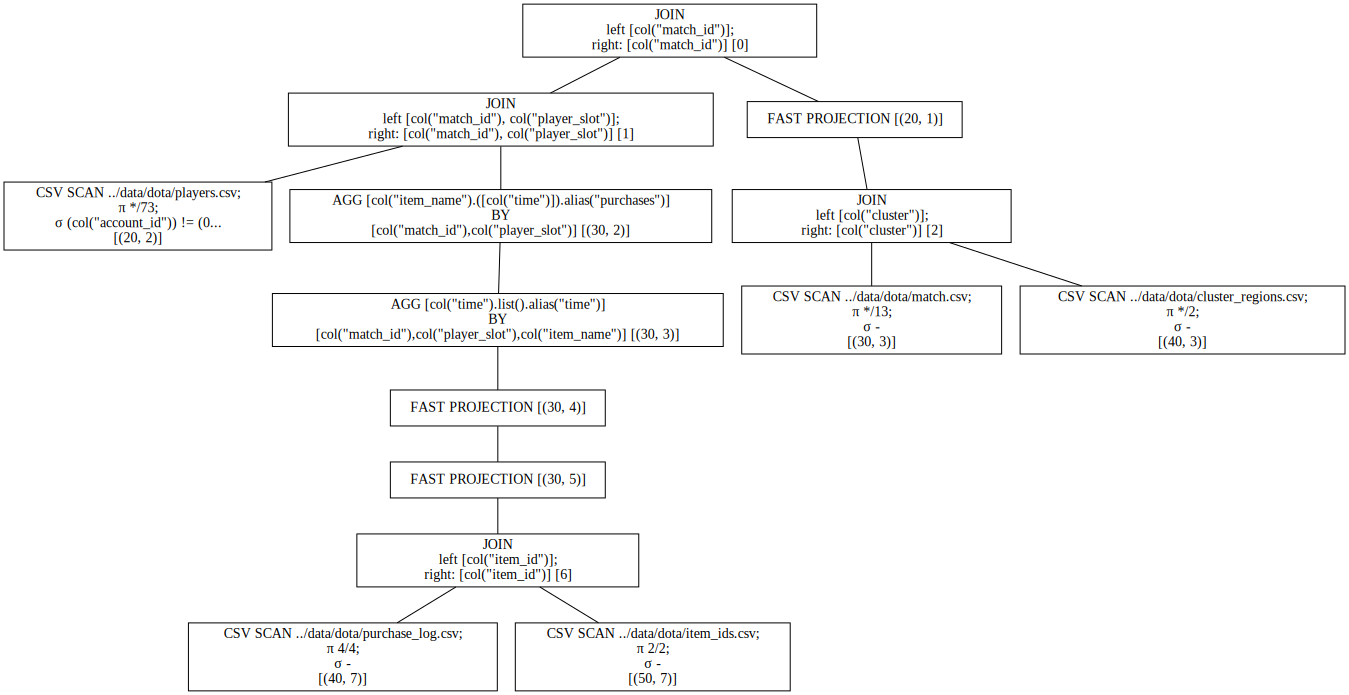

In [7]:
pl_final_lazy.show_graph(optimized=True)


In [8]:
pl_final = pl_final_lazy.collect()

# drop cols with more than 20% NaN
pl_final = pl_final[
    :,
    [
        pl_final[col].null_count() <= 0.2 * pl_final.height
        for col in pl_final.columns
        if col not in ["purchases"]
    ]
    + ["purchases"],
]


In [9]:
pl_final.shape

(318787, 67)

In [16]:
pl_final_fetch = pl_final_lazy.fetch(n_rows=int(1_000))  # take a number of rows from the initial files and run the code -> 18Mio in purchase_log -> 100 Mio limit fetches all data
pl_final_fetch.shape

(15, 86)

In [17]:
pl_final_fetch

match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,...,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,purchases,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,region
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,object,i64,i64,i64,i64,i64,i64,i64,i64,bool,i64,i64,str
0,1,51,1,2954,17760,494,659,13,3,18,9,109,"""87.4164""",23747,0,423,46,63,119,102,24,108,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,null,"""""",1650.0,3299.0,6676.0,4317.0,...,346.0,22.0,null,null,12.0,52.0,30.0,4.0,null,21.0,null,null,"""""",null,null,null,"""""",14.0,null,"""""","""""","""""","""""","""""","{'power_treads': [495], 'staff_of_wizardry': [631, 1058], 'tango': [-77], 'platemail': [1890], 'tpscroll': [239, 408, 1335, 1433, 1911, 1914, 1916], 'flask': [-77], 'shivas_guard': [2084], 'gloves': [399], 'bottle': [286], 'stout_shield': [-76], 'ultimate_orb': [2209], 'magic_stick': [497], 'clarity': [-75, -73, -72], 'vitality_booster': [2189], 'belt_of_strength': [495], 'mystic_staff': [2070], 'point_booster': [1395], 'force_staff': [832], 'boots': [99], 'ring_of_regen': [691], 'ogre_axe': [1058], 'blade_of_alacrity': [1447], 'ultimate_scepter': [1509]}",1446750112,2375,1982,4,3,63,1,22,true,0,1,"""SINGAPORE"""
0,2,11,3,1179,22505,599,605,8,4,19,6,271,"""None""",14832,2714,6055,63,147,154,164,79,160,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,null,"""""",938.0,4714.0,4104.0,10432.0,...,150.0,21.0,null,null,1.0,9.0,45.0,7.0,null,14.0,null,null,"""""",null,1.0,null,"""""",13.0,null,"""""","""""","""""","""""","""""","{'point_booster': [2144], 'belt_of_strength': [822, 1339], 'tango': [-78], 'magic_wand': [478], 'lifesteal': [944], 'tpscroll': [463, 641, 663, 821, 927, 1062, 1679, 1820, 1972, 2006, 2129], 'sange': [1339], 'chainmail': [465], 'boots_of_elves': [1246, 2337], 'buckler': [465], 'manta': [2338], 'orb_of_venom': [1675], 'headdress': [699], 'sange_and_yasha': [1463], 'ultimate_orb': [2144, 2144, 2224], 'skadi': [2144], 'magic_stick': [462], 'gloves': [822], 'bottle': [163], 'helm_of_the_dominator': [944], 'power_treads': [834], 'helm_of_iron_will': [939], 'ogre_axe': [1338], 'blade_of_alacrity': [1246, 2337], 'circlet': [-67, -65], 'branches': [-64, -64, 465, 699], 'mekansm': [714], 'yasha': [1246, 2337], 'ring_of_regen': [699], 'boots': [326]}",1446750112,2375,1982,4,3,63,1,22,true,0,1,"""SINGAPORE"""
0,3,67,4,3307,23825,613,762,20,3,17,13,245,"""None""",33740,243,1833,114,92,147,0,137,63,24,0,15814.0,14325.0,null,62.0,null,-1437.0,-1056.0,"""""",4194.0,3217.0,7467.0,9220.0,...,111.0,23.0,1.0,null,null,2.0,44.0,6.0,null,13.0,null,null,"""""",1.0,3.0,null,"""""",23.0,null,"""""","""""","""""","""""","""""","{'quelling_blade': [213], 'boots_of_elves': [1381, 1403], 'radiance': [1218], 'vitality_booster': [1992], 'manta': [1759], 'ultimate_orb': [1656], 'stout_shield': [-79], 'reaver': [2167], 'ma